## Init

In [1]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from copy import deepcopy
from tqdm.auto import tqdm, trange
import re
import torch
from torch import nn
import torch.nn.functional as F
from collections import defaultdict
from utils import load_imdb
from transformers import AutoModelForCausalLM, AutoTokenizer

sns.set_palette('colorblind')
cmap = sns.color_palette('colorblind')

In [2]:
device = 'cuda'
model = AutoModelForCausalLM.from_pretrained('gpt2-large').to(device)
tokenizer = AutoTokenizer.from_pretrained('gpt2-large')

### Parameter Extraction

In [3]:
emb = model.get_output_embeddings().weight.data.T
num_layers = model.config.n_layer
num_heads = model.config.n_head
hidden_dim = model.config.n_embd
head_size = hidden_dim // num_heads

K = torch.cat([model.get_parameter(f"transformer.h.{j}.mlp.c_fc.weight").T
                           for j in range(num_layers)]).detach()
V = torch.cat([model.get_parameter(f"transformer.h.{j}.mlp.c_proj.weight")
                           for j in range(num_layers)]).detach()
W_Q, W_K, W_V = torch.cat([model.get_parameter(f"transformer.h.{j}.attn.c_attn.weight") 
                           for j in range(num_layers)]).detach().chunk(3, dim=-1)
W_O = torch.cat([model.get_parameter(f"transformer.h.{j}.attn.c_proj.weight") 
                           for j in range(num_layers)]).detach()

K_heads = K.reshape(num_layers, -1, hidden_dim)
V_heads = V.reshape(num_layers, -1, hidden_dim)
d_int = K_heads.shape[1]

W_V_heads = W_V.reshape(num_layers, hidden_dim, num_heads, head_size).permute(0, 2, 1, 3)
W_O_heads = W_O.reshape(num_layers, num_heads, head_size, hidden_dim)
W_Q_heads = W_Q.reshape(num_layers, hidden_dim, num_heads, head_size).permute(0, 2, 1, 3)
W_K_heads = W_K.reshape(num_layers, hidden_dim, num_heads, head_size).permute(0, 2, 1, 3)

In [4]:
sents = load_imdb()
sents = [s for s in sents if len(s) > 100]

Reusing dataset imdb (/home/guydar/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a)


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
ln_f = model.transformer.ln_f
emb_cpu = deepcopy(emb).cpu()
ln_f_cpu = deepcopy(ln_f).cpu()
emb_func = lambda x: ln_f_cpu(x) @ emb_cpu
E1 = emb

### Functions

In [6]:
def dist_matmul(A, B, dist_B=False):
    if dist_B:
        return dist_matmul(B.T, A.T, dist_B=False).T
    B_module = nn.Linear(*B.shape).to(B.device)
    with torch.no_grad():
        nn.init.zeros_(B_module.bias)
        B_module.weight.set_(B.T)
    B_module = nn.DataParallel(B_module)
    res = B_module(A)
    del B_module
    return res

In [7]:
def get_token_freqs(sents):
    token_probs_dict = Counter()
    for s in tqdm(sents):
        for t in tokenizer.encode(s):
            token_probs_dict[t] += 1
    return token_probs_dict

In [8]:
def _batched_recall_metric(xs, y, k=20, k2=3, only_ascii=False):
    if k2 is None:
        k2 = k
    out = []
    xs_idx = torch.topk(xs, k=k, dim=-1).indices
    y_idx = torch.topk(y, k=k2, dim=-1).indices
    for i in range(len(y)):
        A = set(xs_idx[i].ravel().cpu().tolist())
        B = set(y_idx[i].cpu().tolist())
        if only_ascii:
            A, B = map(lambda X: {x for x in X if tokenizer.decode(x).isascii()}, (A, B))
        out.append(len(A & B) / len(B))
    return out        

In [9]:
def _batched_sim(x, y, k=100):
    out = []
    x_idx = torch.topk(x, k=k, dim=-1).indices
    y_idx = torch.topk(y, k=k, dim=-1).indices
    for i in range(len(y)):
        A, B = set(x_idx[i].cpu().tolist()), set(y_idx[i].cpu().tolist())
        out.append(len(A & B) / len(A | B))
    return out

In [10]:
def _plot_comparison(tuples_by_layers, figsize=(15, 9), plots_per_row=2, legend=True):
    fig = plt.figure(figsize=figsize)
    for i, (real, fake, param_name) in enumerate(tuples_by_layers):
        plt.subplot(len(tuples_by_layers) // plots_per_row, plots_per_row, i + 1)
        plt.title(param_name)
        ax = sns.barplot(x='x', y='y', hue='hue',
                    data={'x': [*np.arange(num_layers), *np.arange(num_layers)],
                          'y': [*real, *fake],
                          'hue': (['aligned'] * num_layers) + (['random'] * num_layers),
                    }
                   )
        ax.legend_.remove()
        # plt.xlabel("layer")
    handles, labels = ax.get_legend_handles_labels()
    if legend:
        fig.legend(handles, labels, loc='lower center')

### Memorize Intermediate States

In [11]:
mem = defaultdict(list)
def _memorize_inp_outp(sm, only_last=None):
    global tokenizer
    def f(m, inp, outp):
        inp = inp[0]
        outp = outp[0]
        if only_last:
            inp, outp = inp[-only_last:], outp[-only_last:]
        inp, outp = (inp.squeeze(), outp.squeeze())

        if 'attn.c_proj' in sm:
            mem[f"intermediate-{sm}"].append((inp.cpu().detach(), outp.cpu().detach()))
            inp = inp.reshape(inp.shape[0], num_heads, head_size)
            layer_idx = int(re.search(r'\.h\.(\d+)\.', sm).group(1))
            inp_ = torch.empty(inp.shape[0], inp.shape[1], hidden_dim)
            for head_idx in range(inp.shape[1]):
                inp_[:, head_idx] = (inp[:, head_idx].unsqueeze(1) @ W_O_heads[layer_idx][head_idx]).squeeze()
            inp = inp_
        mem[sm].append((inp.cpu().detach(), outp.cpu().detach()))
    return f
    
submodules = [
              *[f'transformer.h.{j}.attn' for j in range(num_layers)],
              *[f'transformer.h.{j}.attn.c_proj' for j in range(num_layers)],
              *[f'transformer.h.{j}' for j in range(num_layers)],
              *[f'transformer.h.{j}.mlp.c_fc' for j in range(num_layers)],
            ]
if 'mem_hooks' in globals():
    [h.remove() for h in mem_hooks]
mem_hooks = []
for sm in submodules:
    mem_hooks.append(model.get_submodule(sm).register_forward_hook(_memorize_inp_outp(sm)))

In [12]:
sent_stop = 1024
num_sent_samples = 60
sents_sample = np.random.choice(sents, size=num_sent_samples)

In [13]:
for i in trange(num_sent_samples):
    sampled_sent = sents_sample[i] # sents[i] #
    sampled_sent = ' '.join(sampled_sent.split(' ')[:sent_stop])
    model(**{k: v.to(device) if isinstance(v, torch.Tensor) else v
                      for k, v in tokenizer(sampled_sent, return_tensors='pt', truncation=True).items()})

  0%|          | 0/60 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 80.00 MiB (GPU 0; 11.91 GiB total capacity; 11.14 GiB already allocated; 68.94 MiB free; 11.24 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [22]:
del model
torch.cuda.empty_cache()
import gc
gc.collect()

NameError: name 'model' is not defined

## Experiments

In [11]:
max_explored_tokens = 1000
k_ = 50
k2 = k_
only_ascii = False

### Hidden States and Parameters

In [24]:
real_K_recall, fake_K_recall, real_V_recall, fake_V_recall = [], [], [], []

for i1 in trange(num_layers):
    sum_lens = sum([len(x[0]) for x in mem[f'transformer.h.0.mlp.c_fc']])
    tmp1_pre = torch.topk(torch.cat([y for _, y in mem[f'transformer.h.{i1}.mlp.c_fc']])[:max_explored_tokens], 
                          k=5, dim=-1).indices
    tmp1_pre_perm = torch.topk(
        torch.cat([y for _, y in mem[f'transformer.h.{i1}.mlp.c_fc']])[torch.randperm(sum_lens)[:max_explored_tokens]], 
                               k=5, dim=-1).indices
    tmp1_K, tmp1_V = K_heads[i1][tmp1_pre] @ E1, V_heads[i1][tmp1_pre] @ E1
    tmp1_K_perm, tmp1_V_perm = K_heads[i1][tmp1_pre_perm] @ E1, V_heads[i1][tmp1_pre_perm] @ E1
    tmp2 = emb_func(torch.cat([y for _, y in mem[f'transformer.h.{i1}']])[:max_explored_tokens])

    fake_K_recall.append(np.mean(_batched_recall_metric(tmp1_K_perm, tmp2, k=k_, k2=k2, only_ascii=only_ascii)))
    real_K_recall.append(np.mean(_batched_recall_metric(tmp1_K, tmp2, k=k_, k2=k2, only_ascii=only_ascii)))
    fake_V_recall.append(np.mean(_batched_recall_metric(tmp1_V_perm, tmp2, k=k_, k2=k2, only_ascii=only_ascii)))
    real_V_recall.append(np.mean(_batched_recall_metric(tmp1_V, tmp2, k=k_, k2=k2, only_ascii=only_ascii)))

  0%|          | 0/36 [00:00<?, ?it/s]

IndexError: index 3726 is out of bounds for dimension 0 with size 3416

In [16]:
real_WV_recall, fake_WV_recall, real_WO_recall, fake_WO_recall = [], [], [], []

for i1 in trange(num_layers):
    tmp1_pre = torch.topk(torch.cat(
        [x for x, _ in mem[f'intermediate-transformer.h.{i1}.attn.c_proj']])[:max_explored_tokens], k=5, dim=-1).indices
    tmp1_x, tmp1_y = np.unravel_index(tmp1_pre.numpy(), (num_heads, head_size))
    del tmp1_pre
    tmp1_WV, tmp1_WO = W_V_heads[i1, tmp1_x, :, tmp1_y] @ E1, W_O_heads[i1, tmp1_x, tmp1_y] @ E1
    tmp1 = tmp1_WV
    tmp2 = emb_func(torch.cat([y for _, y in mem[f'transformer.h.{i1}']])[:max_explored_tokens])
    
    fake_WV_recall.append(np.mean(_batched_recall_metric(tmp1_WV[torch.randperm(len(tmp1_WV))], tmp2, k=k_, k2=k2,
                                                         only_ascii=only_ascii)))
    real_WV_recall.append(np.mean(_batched_recall_metric(tmp1_WV, tmp2, k=k_, k2=k2, only_ascii=only_ascii)))
    fake_WO_recall.append(np.mean(_batched_recall_metric(tmp1_WO[torch.randperm(len(tmp1_WO))], tmp2, k=k_, k2=k2,
                                                         only_ascii=only_ascii)))
    real_WO_recall.append(np.mean(_batched_recall_metric(tmp1_WO, tmp2, k=k_, k2=k2, only_ascii=only_ascii)))

  0%|          | 0/24 [00:00<?, ?it/s]

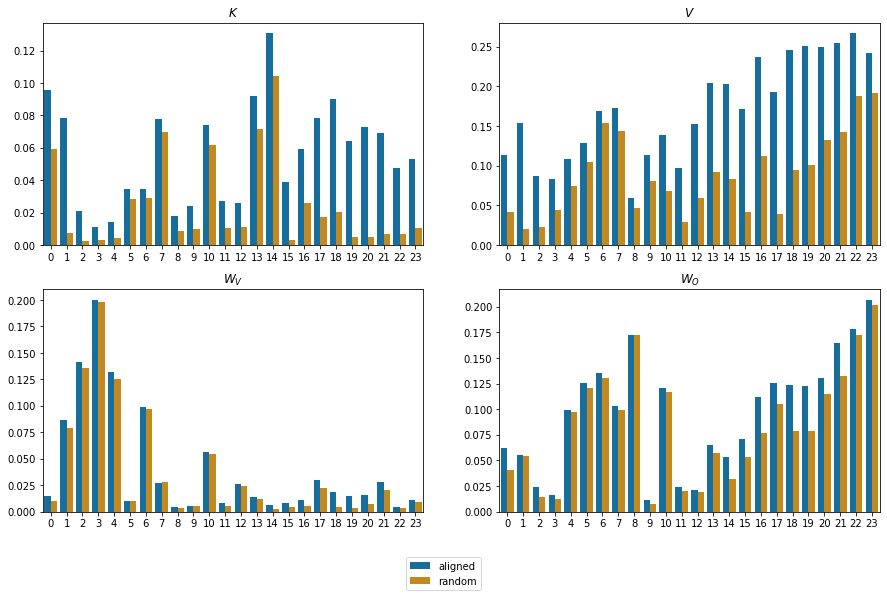

In [17]:
_plot_comparison([(real_K_recall, fake_K_recall, "$K$"),
                  (real_V_recall, fake_V_recall, "$V$"),
                  (real_WV_recall, fake_WV_recall, "$W_V$"),
                  (real_WO_recall, fake_WO_recall, "$W_O$")
                 ])
plt.savefig("artifacts/weights_vs_states.pdf")

### Related Parameter Pairs are Connected

In [12]:
intersections_dict = {}

In [13]:
intersections_dict['KV'] = np.array([_batched_sim(abs(K_heads[l] @ E1), abs(V_heads[l] @ E1)) for l in trange(num_layers)])

intersections_dict['KV_shuffled'] = np.array([_batched_sim(abs(K_heads[l][torch.randperm(K_heads.shape[1])] @ E1), 
                                                            abs(V_heads[l] @ E1)) for l in trange(num_layers)])

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

In [20]:
intersections_dict['W_VO'] = np.array([_batched_sim(abs(W_V_heads[l].permute(0, 2, 1).flatten(0, 1) @ E1), 
                                                                  abs(W_O_heads[l].flatten(0, 1) @ E1)) 
                                           for l in trange(num_layers)])

intersections_dict['W_VO_shuffled'] = np.array([_batched_sim(abs(W_V_heads[l].permute(0, 2, 1).flatten(0, 1) @ E1),
                                                             abs(W_O_heads[l].flatten(0, 1)[torch.randperm(W_O_heads.size(-1))] @ E1)) 
                                                    for l in trange(num_layers)])

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [21]:
intersections_dict['W_QK'] = np.array([_batched_sim(abs(W_Q_heads[l].permute(0, 2, 1).flatten(0, 1) @ E1), 
                                                    abs(W_K_heads[l].permute(0, 2, 1).flatten(0, 1) @ E1)) 
                                           for l in trange(num_layers)])

intersections_dict['W_QK_shuffled'] = np.array([_batched_sim(abs(W_Q_heads[l].permute(0, 2, 1).flatten(0, 1) @ E1), 
                                    abs(W_K_heads[l].permute(0, 2, 1).flatten(0, 1)[torch.randperm(W_K_heads.size(-1))] @ E1)) 
                                    for l in trange(num_layers)])

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [27]:
_plot_comparison([(np.mean(intersections_dict['KV'], axis=-1), np.mean(intersections_dict['KV_shuffled'], axis=-1), '$K$ and $V$'),
                  (np.mean(intersections_dict['W_VO'], axis=-1), np.mean(intersections_dict['W_VO_shuffled'], axis=-1), '$W_V$ and $W_O$'),
                 ], figsize=(14, 4), legend=False) # , figsize=(35, 7), plots_per_row=3
plt.savefig('artifacts/related_pairs1.pdf')

KeyError: 'W_VO'

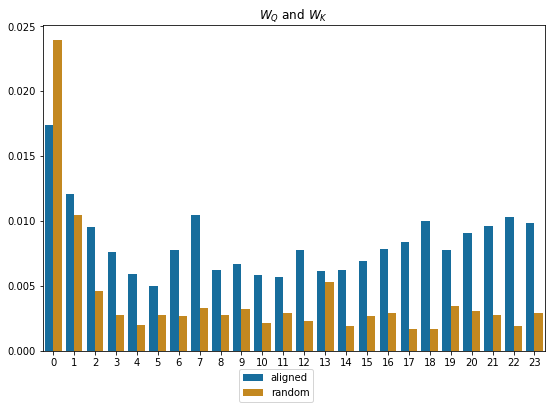

In [23]:
_plot_comparison([(np.mean(intersections_dict['W_QK'], axis=-1), np.mean(intersections_dict['W_QK_shuffled'], axis=-1), 
                   '$W_Q$ and $W_K$')], figsize=(9, 6), plots_per_row=1)
plt.savefig('artifacts/related_pairs2.pdf')

### Finding Interesting K, V Pairs

In [16]:
sim_scores = np.stack([_batched_sim(K_heads[l] @ E1, V_heads[l] @ E1) for l in trange(num_layers)])

  0%|          | 0/36 [00:00<?, ?it/s]

In [26]:
interesting_pairs = torch.nonzero(torch.from_numpy(sim_scores) > .4)

In [27]:
interesting_pairs[1000:1100]

tensor([[   6, 2152],
        [   6, 2164],
        [   6, 2180],
        [   6, 2201],
        [   6, 2247],
        [   6, 2263],
        [   6, 2298],
        [   6, 2299],
        [   6, 2308],
        [   6, 2325],
        [   6, 2350],
        [   6, 2356],
        [   6, 2391],
        [   6, 2527],
        [   6, 2568],
        [   6, 2581],
        [   6, 2589],
        [   6, 2657],
        [   6, 2784],
        [   6, 2852],
        [   6, 2864],
        [   6, 2874],
        [   6, 2881],
        [   6, 2922],
        [   6, 2928],
        [   6, 3076],
        [   6, 3085],
        [   6, 3187],
        [   6, 3215],
        [   6, 3232],
        [   6, 3297],
        [   6, 3300],
        [   6, 3304],
        [   6, 3325],
        [   6, 3339],
        [   6, 3352],
        [   6, 3358],
        [   6, 3369],
        [   6, 3370],
        [   6, 3388],
        [   6, 3403],
        [   6, 3500],
        [   6, 3555],
        [   6, 3557],
        [   6, 3560],
        [ 

### Model Logits (*Last* Hidden States) and Parameters

In [194]:
real_K_recall2, fake_K_recall2, real_V_recall2, fake_V_recall2 = [], [], [], []

for i1 in trange(num_layers):
    sum_lens = sum([len(x[0]) for x in mem[f'transformer.h.0.mlp.c_fc']])
    tmp1_pre = torch.topk(torch.cat([y for _, y in mem[f'transformer.h.{i1}.mlp.c_fc']])[:max_explored_tokens], 
                          k=5, dim=-1).indices
    tmp1_pre_perm = torch.topk(
        torch.cat([y for _, y in mem[f'transformer.h.{i1}.mlp.c_fc']])[torch.randperm(sum_lens)[:max_explored_tokens]], 
                               k=5, dim=-1).indices
    tmp1_K, tmp1_V = K_heads[i1][tmp1_pre] @ E1, V_heads[i1][tmp1_pre] @ E1
    tmp1_K_perm, tmp1_V_perm = K_heads[i1][tmp1_pre_perm] @ E1, V_heads[i1][tmp1_pre_perm] @ E1
    tmp2 = emb_func(torch.cat([y for _, y in mem[f'transformer.h.{num_layers-1}']])[:max_explored_tokens])

    fake_K_recall2.append(np.mean(_batched_recall_metric(tmp1_K_perm, tmp2, k=k_, k2=k2, only_ascii=only_ascii)))
    real_K_recall2.append(np.mean(_batched_recall_metric(tmp1_K, tmp2, k=k_, k2=k2, only_ascii=only_ascii)))
    fake_V_recall2.append(np.mean(_batched_recall_metric(tmp1_V_perm, tmp2, k=k_, k2=k2, only_ascii=only_ascii)))
    real_V_recall2.append(np.mean(_batched_recall_metric(tmp1_V, tmp2, k=k_, k2=k2, only_ascii=only_ascii)))

  0%|          | 0/24 [00:00<?, ?it/s]

In [195]:
real_WV_recall2, fake_WV_recall2, real_WO_recall2, fake_WO_recall2 = [], [], [], []

for i1 in trange(num_layers):
    tmp1_pre = torch.topk(torch.cat(
        [x for x, _ in mem[f'intermediate-transformer.h.{i1}.attn.c_proj']])[:max_explored_tokens], 
                          k=5, dim=-1).indices
    tmp1_x, tmp1_y = np.unravel_index(tmp1_pre.numpy(), (num_heads, head_size))
    del tmp1_pre
    tmp1_WV, tmp1_WO = W_V_heads[i1, tmp1_x, :, tmp1_y] @ E1, W_O_heads[i1, tmp1_x, tmp1_y] @ E1
    tmp1 = tmp1_WV
    tmp2 = emb_func(torch.cat([y for _, y in mem[f'transformer.h.{num_layers-1}']])[:max_explored_tokens])
    fake_WV_recall2.append(np.mean(_batched_recall_metric(tmp1_WV[torch.randperm(len(tmp1_WV))], tmp2, 
                                                          k=k_, k2=k2, only_ascii=only_ascii)))
    real_WV_recall2.append(np.mean(_batched_recall_metric(tmp1_WV, tmp2, k=k_, k2=k2, only_ascii=only_ascii)))
    fake_WO_recall2.append(np.mean(_batched_recall_metric(tmp1_WO[torch.randperm(len(tmp1_WO))], tmp2, 
                                                          k=k_, k2=k2, only_ascii=only_ascii)))
    real_WO_recall2.append(np.mean(_batched_recall_metric(tmp1_WO, tmp2, k=k_, k2=k2, only_ascii=only_ascii)))

  0%|          | 0/24 [00:00<?, ?it/s]

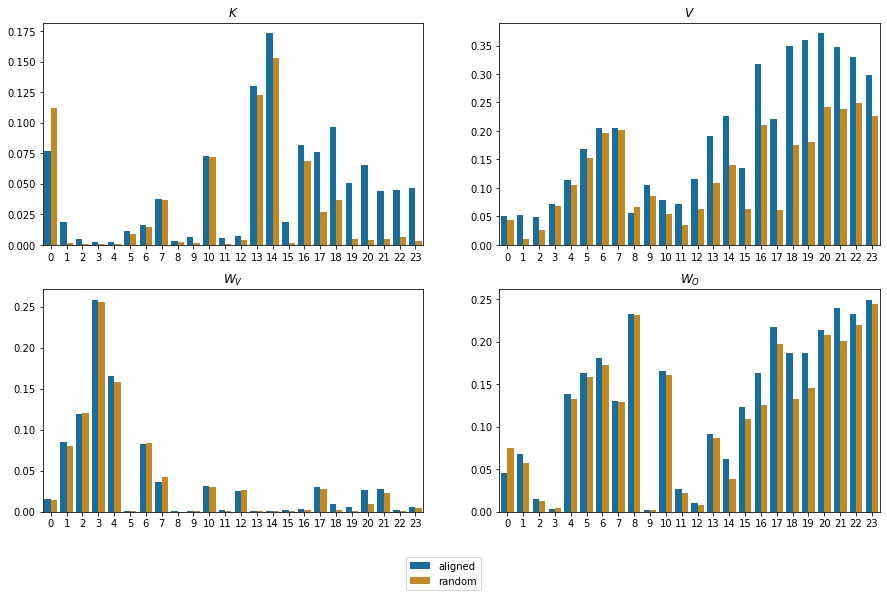

In [230]:
_plot_comparison([(real_K_recall2, fake_K_recall2, "$K$"),
                  (real_V_recall2, fake_V_recall2, "$V$"),
                  (real_WV_recall2, fake_WV_recall2, "$W_V$"),
                  (real_WO_recall2, fake_WO_recall2, "$W_O$")
                 ])
plt.savefig("artifacts/weights_vs_logits.pdf")

## Bonus: Comparing Inverses

In [24]:
def _choose_from_tensor(tensor, n):
    tensor = tensor.view(-1, tensor.size(-1))
    return tensor[torch.randperm(len(tensor))[:n]]

In [25]:
n_samples = 1000

In [26]:
X_ff_values = _choose_from_tensor(V, n=n_samples).cuda()
X_randn = torch.randn(n_samples, hidden_dim).cuda()

In [27]:
X_hidden = [torch.cat([out_state for (_, out_state) in val], dim=0) 
            for (name, val) in mem.items() if re.search(r'transformer\.h\.\d+$', name)]
X_hidden = torch.cat(X_hidden, dim=0)
X_hidden = _choose_from_tensor(X_hidden, n=n_samples).cuda()

### keep-k inverse robustness

In [28]:
from utils import keep_k

In [29]:
E = emb

In [30]:
E_inv = E.pinverse()

In [31]:
plot_pos_low = [10,  50, 100, 200, 300, 500]
plot_pos_high = [512, 1024 , 2048, 4096, 10_000, 15_000, 20_000, 30_000]

In [34]:
plot_range = 'high'

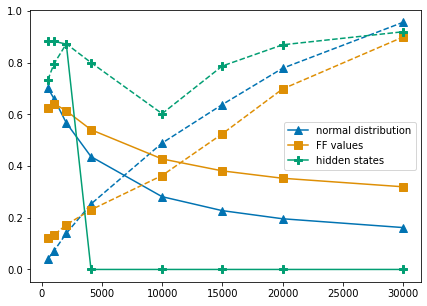

In [35]:
plt.figure(figsize=(7, 5))
markers = ['^', 's', 'P']
plot_pos = plot_pos_low if plot_range == 'low' else plot_pos_high

for i, (X, label) in enumerate([(X_randn, "normal distribution"), (X_ff_values, "FF values"), (X_hidden, "hidden states")]):
    plot_scores_E = []
    plot_scores_inv = []

    for k1 in plot_pos:
        plot_scores_E.append(F.cosine_similarity((X @ X.T).ravel(),
                                               (keep_k(X @ E, k=k1) @ keep_k(X @ E, k=k1).T).ravel(), dim=0).item())
        plot_scores_inv.append(F.cosine_similarity((X @ X.T).ravel(),
                                               (keep_k(X @ E, k=k1) @ keep_k(X @ E_inv.T, k=k1).T).ravel(), dim=0).item())
    plt.plot(plot_pos, plot_scores_E, c=cmap[i], label=label, marker=markers[i], markersize=8)
    plt.plot(plot_pos, plot_scores_inv, '--', c=cmap[i], marker=markers[i], markersize=8);

plt.legend()
plt.savefig("artifacts/e_vs_e_inv.pdf" if plot_range == 'low' else "artifacts/e_vs_e_inv_high.pdf");